# Titanic - Binary Classification

As widely known, Titanic was a British liner that was meant to travel from Southampton to New York in the spring of 1912. Unfornatunaly, it struck an iceberg during the trip that caused the catastrophic sinking of the liner and consequently many lifes were lost. The intention of this project is to find a suitable machine learning learning model that can accurately predict whether a passenger is likely to survive or die based on a series of features that characterize each one of them. To that end, two datasets are provided; a train and a test dataset. The first one is used to train and find the most adequate model by means of supervised learning techniques. The latter dataset contains information of all the features of each passenger as well as the target information, that is, whether he/she survived the tragic accident. The test dataset however, only contain the feature values. Having the target values in advance will be useful to evaluate the accuracy of the model. In this way, the selection of the proper learning algorithm is done by means of an assesment of a series of different classification models in the training set. Finally, the selected model is applied to the test data to predict the number of survivors.

<img src="titanic_2.jpg" width="800" height="350" align="center"/>

## Table of Contents
1. Train and test data
2. Check missing and duplicated data
3. New features
4. Feature dependencies
5. Fill missing data
6. Pipeline and training models
    * 6.1. Logistic Regression
    * 6.2. SVC: linear kernel
    * 6.3. SVC: RBF kernel
    * 6.4. SVC: polynomial kernel
    * 6.5. Decision Tree Classifier
7. Feature impact on accuracy
8. Test data - make predictions

## 1. Train and test data

Firstly, let's load the necessary packages:

In [4]:
# Import packages

import pandas as pd 
import numpy as np 
import math 
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict, validation_curve, learning_curve

Now, let's load the train and test data that we will be using:

In [321]:
# Load the train and test data

train_data = pd.read_csv("./train.csv")

test_data = pd.read_csv("./test.csv")

Let's take a look into the training data and test data:

In [322]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [323]:
print(f'The training data has {train_data.shape[0]} rows and {train_data.shape[1]} columns')

The training data has 891 rows and 12 columns


In [324]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [325]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Now let's dive into these features and their meaning:

    Survival - Whether the passenger did survive or no (0 = No / 1 = Yes)
    Pclass -  Passenger's Travel Class (1 = First class and thus the best one)
    Name - Name of the passenger
    Sex - Sex (Male/Female)
    Age - Passenger's age
    Sibsp - Number of Siblings/Spouses aboard
    Parch - Number of Parents/Children aboard
    Ticket - Ticket Number
    Fare - Passenger Fare
    Cabin - Cabin
    Embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


In [326]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [327]:
print(f'The test data has {test_data.shape[0]} rows and {test_data.shape[1]} columns')

The test data has 418 rows and 11 columns


In [328]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [329]:
test_data.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


We look at the target:

In [330]:
y = set(train_data.columns).difference(set(test_data.columns))
print(f'The target is {y}')

The target is {'Survived'}


Let's see how many passengers survived and how many did not:

In [331]:
train_data[y].value_counts()

Survived
0           549
1           342
dtype: int64

Keep in mind the target feature is binary, 0 value representing 'not survived' and 1 value representing 'survived'.

Now we take a closer look to the features in the training data:

In [332]:
print(f'We have {len(train_data.columns)-1} features and 1 target')

We have 11 features and 1 target


In [333]:
pd.concat([train_data.dtypes, train_data.nunique()], axis=1, keys = ['Type', 'Unique Val'])

,Type,Unique Val
PassengerId,int64,891
Survived,int64,2
Pclass,int64,3
Name,object,891
Sex,object,2
Age,float64,88
SibSp,int64,7
Parch,int64,7
Ticket,object,681
Fare,float64,248


We can see that features 'PassengerId' and 'Name' features are all unique as they have the same number of values as rows are. Therefore, they will not have an influence on the target value.

Moreover, we change the type of 'Sex', 'Embarked' and 'Pclass' to categorical type:

In [334]:
train_data['Sex'] = pd.Categorical(train_data['Sex'])
train_data['Embarked'] = pd.Categorical(train_data['Embarked'])
train_data['Pclass'] = pd.Categorical(train_data['Pclass'])
train_data['Survived'] = pd.Categorical(train_data['Survived'])

test_data['Sex'] = pd.Categorical(test_data['Sex'])
test_data['Embarked'] = pd.Categorical(test_data['Embarked'])
test_data['Pclass'] = pd.Categorical(test_data['Pclass'])

In [335]:
train_data.drop('Ticket', axis=1, inplace= True)
test_data.drop('Ticket', axis=1, inplace= True)

We check the categorical features have been properly set:

In [336]:
train_data.dtypes

PassengerId       int64
Survived       category
Pclass         category
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Fare            float64
Cabin            object
Embarked       category
dtype: object

In [337]:
test_data.dtypes

PassengerId       int64
Pclass         category
Name             object
Sex            category
Age             float64
SibSp             int64
Parch             int64
Fare            float64
Cabin            object
Embarked       category
dtype: object

## 2. Check missing and duplicated data

Now we create a funstion to check for missing data and duplicates if any:

In [338]:
def check_missing_duplicates(dataset):
    
    # Calculate the number and percentage of missing values per column
    
    missing_values = dataset.isnull().sum()
    percentage_missing = np.array(missing_values*100/len(dataset))
    missing_val_per = list(zip(missing_values, np.around(percentage_missing,2), dataset.dtypes))
    col_names = ['Missing Values', 'Percentage %','Type']
    df = pd.DataFrame(data= missing_val_per,columns = col_names, index = dataset.columns)   
    print(f'Missing Values and Percentage are:\n\n{df}')

    max_miss_val, max_miss_id = (df['Percentage %'].max(), df['Percentage %'].idxmax())

    print(f'\nThere are plenty of missing values for feature "{max_miss_id}" accounting for {max_miss_val}\
    % of the data.')

    # Find maximum number of missing values in a row. If there are lots of missing features in a row, it should be 
    # considered to delete that row
    
    missing = dataset.isnull().sum(axis=1)
    print(f'A maximum of {missing.max()} values are missed in a row.')

    # Check duplicates
    
    duplicates = dataset[dataset['PassengerId'].duplicated()]
    print(f'There are {len(duplicates)} duplicates.')

We check the missing data and duplicates in the training and test data:

In [339]:
check_missing_duplicates(train_data)

Missing Values and Percentage are:

             Missing Values  Percentage %      Type
PassengerId               0          0.00     int64
Survived                  0          0.00  category
Pclass                    0          0.00  category
Name                      0          0.00    object
Sex                       0          0.00  category
Age                     177         19.87   float64
SibSp                     0          0.00     int64
Parch                     0          0.00     int64
Fare                      0          0.00   float64
Cabin                   687         77.10    object
Embarked                  2          0.22  category

There are plenty of missing values for feature "Cabin" accounting for 77.1    % of the data.
A maximum of 2 values are missed in a row.
There are 0 duplicates.


In [340]:
check_missing_duplicates(test_data)

Missing Values and Percentage are:

             Missing Values  Percentage %      Type
PassengerId               0          0.00     int64
Pclass                    0          0.00  category
Name                      0          0.00    object
Sex                       0          0.00  category
Age                      86         20.57   float64
SibSp                     0          0.00     int64
Parch                     0          0.00     int64
Fare                      1          0.24   float64
Cabin                   327         78.23    object
Embarked                  0          0.00  category

There are plenty of missing values for feature "Cabin" accounting for 78.23    % of the data.
A maximum of 2 values are missed in a row.
There are 0 duplicates.


Due to the high percentage of missing values in 'Cabin' this feature will be removed. We will deal the rest of missing values later.

In [341]:
train_data.drop('Cabin', axis=1, inplace= True)
test_data.drop('Cabin', axis=1, inplace= True)

## 3. New features

Let's now create features that could potentially be more useful in the process of accurately predicting the target. For example, let's gather 'Surname' and 'Title' features from the 'Name' column:

In [342]:
def split_name_surname_title(dataset):

        # Separate Surname and Name 
        dataset[['Surname', 'Name']] = dataset.Name.str.split(',',expand=True)

        # Separate Name and Title 
        dataset[['Title', 'Name']] = dataset.Name.str.split('.',expand=True).iloc[:,0:2]

        # Remove unnecessary spaces 
        dataset['Title'] = dataset['Title'].str.strip()
        #dataset['Name'] = dataset['Name'].str.strip()

In [343]:
# Split Name into Name, Surname and Title
split_name_surname_title(train_data)
split_name_surname_title(test_data)

Now we set them as categorical:

In [344]:
train_data['Title'] = pd.Categorical(train_data['Title'])

test_data['Title'] = pd.Categorical(test_data['Title'])

In [345]:
train_data.drop(['Name','Surname'], axis=1, inplace= True)
test_data.drop(['Name','Surname'], axis=1, inplace= True)

Now we check the columns have been correctly created:

In [346]:
train_data.head(1)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,male,22.0,1,0,7.25,S,Mr


In [347]:
test_data.head(1)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,892,3,male,34.5,0,0,7.8292,Q,Mr


We can also gather together 'Parch' and 'SibSp' and create a new feature called 'Family' with the total number of relatives each passenger is traveling with. 

In [348]:
# Create 'Family' feature out of 'SibSp' and 'Parch'
train_data['Family'] = train_data['SibSp'] + train_data['Parch']
test_data['Family'] = test_data['SibSp'] + test_data['Parch']

Now we check the columns have been correctly created:

In [349]:
train_data.head(1)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family
0,1,0,3,male,22.0,1,0,7.25,S,Mr,1


In [350]:
test_data.head(1)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family
0,892,3,male,34.5,0,0,7.8292,Q,Mr,0


## 4. Features' dependencies

Let's now dive into which features are more determinant when predicting the target.

In [351]:
def make_plot_scores(dataset, feature, regression=False):

    # Create a copy of the train data removing all the rows containing missing values
    df_copy = dataset.dropna().drop('PassengerId', axis=1).copy()

    # We set the target
    y_copy = df_copy.pop(feature)

    # Label object or category columns
    label_encoder = LabelEncoder()

    # We select categorical object and columns
    cat_cols = df_copy.select_dtypes(['object','category']).columns

    for col in cat_cols:
        df_copy[col] = label_encoder.fit_transform(df_copy[col])

    discrete_features = df_copy.columns.isin(cat_cols)

    # Obtain scores of mutual information

    if regression:
        scores = mutual_info_regression(df_copy, y_copy, discrete_features=discrete_features, random_state = 1)

    else:
        scores = mutual_info_classif(df_copy, y_copy, discrete_features=discrete_features, random_state = 1)

    scores = pd.Series(scores, name="Scores", index=df_copy.columns)

    # Retain positive non-zero scores
    scores = scores[scores > 0].sort_values(ascending = False)
    
    # Create bar plot
    width = np.arange(len(scores))
    ticks = list(scores.index)

    sns.set_style('whitegrid')
    sns.barplot(x = scores, y = width, orient='h', color='lightseagreen')
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

    return scores.sort_values(ascending = False)

In order to better visualize the relationship between features, we create a function that creates a plot of these:

Title       0.177860
Sex         0.148409
Fare        0.133968
Pclass      0.065163
Family      0.049328
SibSp       0.026564
Embarked    0.019310
Parch       0.011632
Name: Scores, dtype: float64

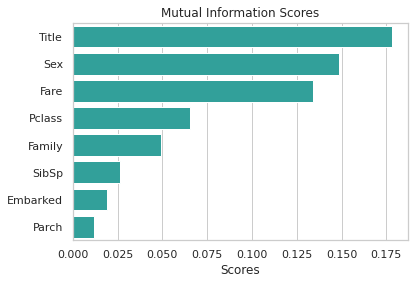

In [352]:
scores = make_plot_scores(train_data, 'Survived')
scores

We create a copy of our train data with an additional column stating the survival status and convert categorical features to 'object' for visualization purposes:

In [353]:
train_copy = train_data.copy()

# Create Status column
train_copy['Status'] = 'Survived'
train_copy.loc[train_copy.Survived == 0, 'Status'] = 'Not Survived'

train_copy['Status'] = pd.Categorical(train_copy['Status'])

In [354]:
def make_barplot(feature1, feature2, dataset=train_copy, horizontal = False):

    # Chance 'category' type to 'object' type for visualization purposes
    dataset_obj = dataset.copy()
    cat_cols = dataset_obj.select_dtypes('category').columns
    dataset_obj[cat_cols] = dataset_obj[cat_cols].astype('object')

    if horizontal: 

        # We only select the most repeated values for better visualization
        val_count = dataset_obj[feature2].value_counts()
        condition = val_count > 3
        val_selection = val_count[condition].index.to_list()

        condition2 = dataset_obj[feature2].isin(val_selection)
        df = dataset_obj[condition2]
        df_group = df.groupby(feature2)[feature1].value_counts(normalize=True).mul(100).rename('Percentage %').reset_index()

    
        sns.barplot(y=feature2, x='Percentage %', hue=feature1, data=df_group, orient= 'h', palette = 'rainbow', edgecolor=(0,0,0))
        plt.xlim([0,100])
        plt.legend(loc='best', title=feature1)
        fg = plt.gcf()
        ax = plt.gca()

        for p in ax.patches:
            ax.annotate(f'{round(p.get_width(),1)}%', 
                        (p.get_width(), p.get_y() + p.get_height() / 2.), 
                        ha = 'center', va = 'center', 
                        xytext = (30, 0), 
                        textcoords = 'offset points')

    else: 
        df = dataset_obj.groupby(feature1)[feature2].value_counts(normalize=True).mul(100).rename('Percentage %').reset_index()
        sns.barplot(x=feature1, y='Percentage %', hue=feature2, data=df, palette = 'spring_r', edgecolor=(0,0,0)) 

        plt.ylim([0,100])
        plt.legend(loc='best', title=feature2)

        fg = plt.gcf()
        ax = plt.gca()

        for p in ax.patches:
            ax.annotate(f'{round(p.get_height(),1)}%', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha = 'center', va = 'center', 
                        xytext = (0, 9), 
                        textcoords = 'offset points')

    return (ax, fg)


In [355]:
def make_boxplot(feature1, feature2, dataset=train_copy):

    # Chance 'category' type to 'object' type for visualization purposes
    dataset_obj = dataset.copy()
    cat_cols = dataset_obj.select_dtypes('category').columns
    dataset_obj[cat_cols] = dataset_obj[cat_cols].astype('object')

    # We only select the most repeated values for better visualization
    val_count = dataset_obj[feature2].value_counts()
    condition = val_count > 3
    val_selection = val_count[condition].index.to_list()

    condition2 = dataset_obj[feature2].isin(val_selection)
    df = dataset_obj[condition2]

    pt = sns.boxplot(data=df, y=feature1, x =feature2, palette = 'rainbow')

    return pt


### Title 

We start looking the survival rate per passengers' title. Taking into account that there are several titles and most of them only appear once, we only look at those which are most repeated for plotting:

In [356]:
train_copy.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Col               2
Mlle              2
Sir               1
Ms                1
Capt              1
Mme               1
Lady              1
Jonkheer          1
Don               1
the Countess      1
Name: Title, dtype: int64

Now let's plot the survival rate per titles:

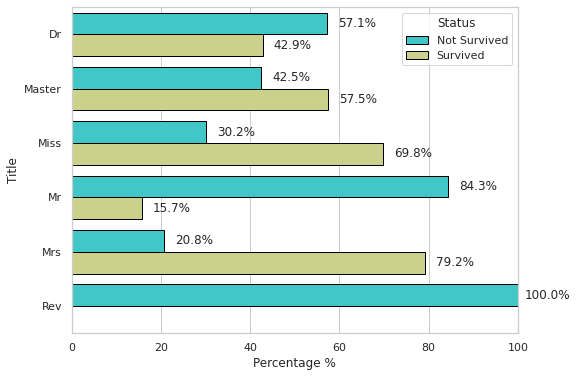

In [357]:
ax, fg = make_barplot('Status', 'Title', horizontal=True)
fg.set_size_inches(8,6);

As observed, most of passengers with title 'Mr' died in the accident whereas most of passengers with title 'Mrs', 'Miss' and 'Master' survived. This makes sense as 'Mr' is the title commonly used for adult men whereas 'Mrs', 'Miss' and 'Master' are referred to adult married women, unmarried women or young girls and boys respectively. Therefore, one can see that women and children were most likely to survive the catastrophe.  

### Sex 

Now let's look at the sex influence on the survival rate:

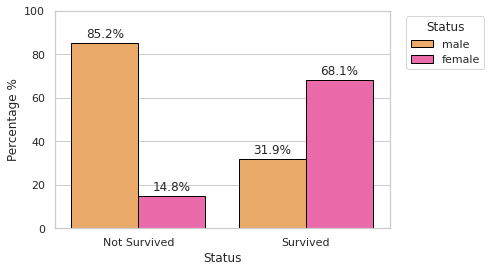

In [358]:
ax, fg = make_barplot('Status','Sex')
ax.legend(loc='upper right', title='Status', bbox_to_anchor=(1.3, 1));

It can be clearly seen that male presented a very high likelihood of deceasing. On the other hand, women were most likely to survive. This was to be expected as the previous image already reflected this insight in the titles used for men and women. 

### Fare 

Let's continue with looking at how the different fares affect the probabilities of survival:

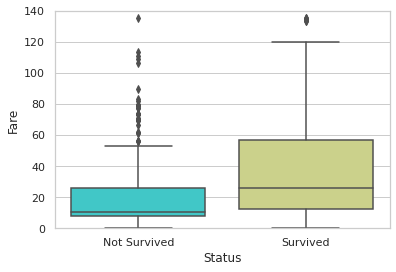

In [359]:
pt = make_boxplot('Fare','Status')
pt.set_ylim(0,140);

We can see that higher fares lead to more chance of survival. This also makes sense as the best rooms are more expensive and better located than cheaper ones, thus safer.

### Passenger's class 

We now look at the passengers' class:

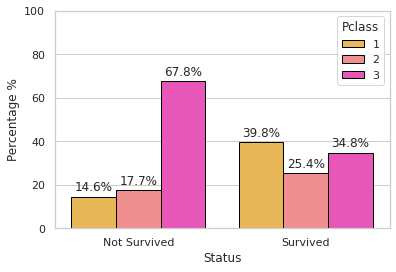

In [360]:
make_barplot('Status','Pclass');

Considering that the first class is the best one and the third one the worst one, it can be seen a clear influence of the class quality on the survival rate. This is also linked to the paid fares, as the best classes are the most expensive ones and thus better rooms, location, etc. The latter can be illustrated as the following:

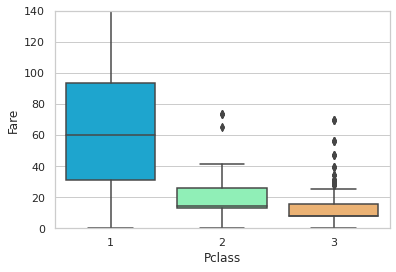

In [361]:
pt = make_boxplot('Fare','Pclass')
pt.set_ylim(0,140);

### Family

The next feature to analyze is the family size. As seen in the figure below, there is a high mortaily rate in families above four members as well as those who were alone. In medium-small families including one to three members the probability of staying alive increases. The reason for this could be that single passengers did not directly have anyone that could take care of them. As the number of relatives increase, more people look after each other. Nonetheless, the latter comes to a limit and therefore in the case of big families the mortaily rate increases just simply because there are many people to be taken care of.

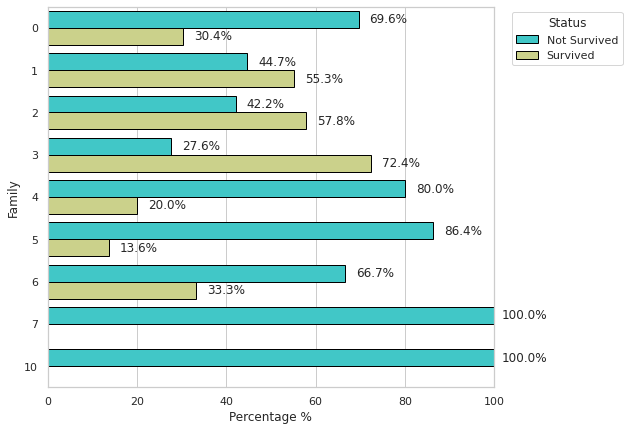

In [362]:
pt, fg = make_barplot('Status', 'Family', horizontal=True)
pt.legend(loc='upper right', title='Status', bbox_to_anchor=(1.3, 1))
fg.set_size_inches(8,7);

If we now look at the passengers' class we can find that most big families and single passengers mainly traveled in third class. This could also explain the mortality rates. 

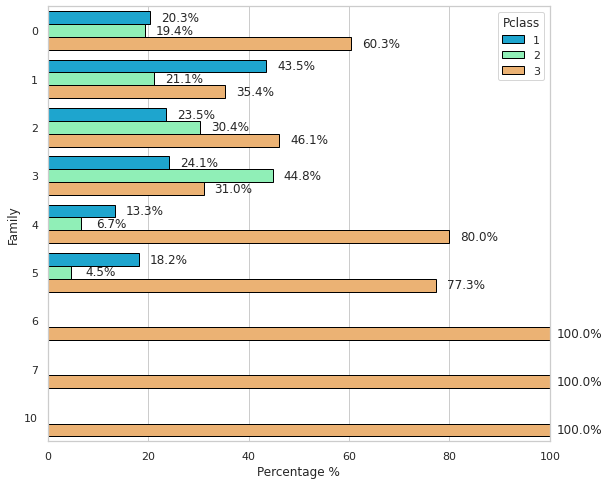

In [363]:
pt, fg = make_barplot('Pclass', 'Family', horizontal=True)
fg.set_size_inches(9,8);

### Embarked feature

If the now look at the location of embarkation, we can see that most of the passengers that got onboard at Southampton and Queenstown were more likely to not survive:

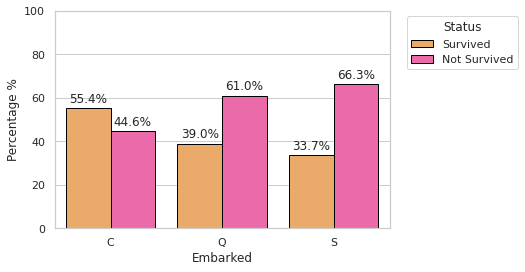

In [364]:
ax, fg = make_barplot('Embarked', 'Status')
ax.legend(loc='upper right', title='Status', bbox_to_anchor=(1.4, 1));

In the next graphs, we can see the latter is mainly due to the fact that embarkation ports are related to the paid fare and travel class. Passengers boarding at Cherbourg paid higher rates and were assigned better classes whereas passengers from Southampton and specially Queenstown paid cheaper fares and thus worse classes:

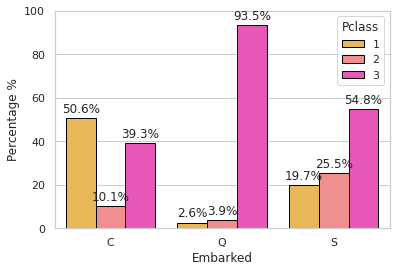

In [365]:
make_barplot('Embarked', 'Pclass');

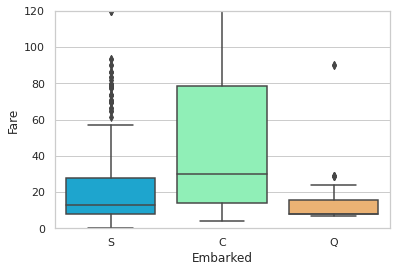

In [366]:
pt = make_boxplot('Fare', 'Embarked')
pt.set_ylim(0,120);

### Age feature

Let's continue with age feature:

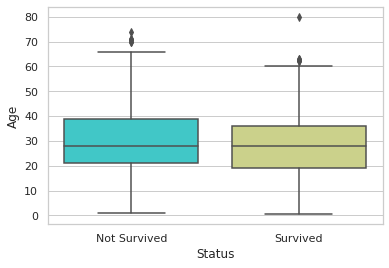

In [367]:
make_boxplot('Age','Status');

As seen, the age distribution is very similar and the mean value is pretty close in both status. We can slightly see an effect that might suggest that there are more older people in the status of not survived.

Taking into account that there are a considerable amount of missing age values let's now take a closer look to this feature. We first compute the mutual relation scores:

Title       0.177860
Sex         0.148409
Fare        0.133968
Pclass      0.065163
Family      0.049328
SibSp       0.026564
Embarked    0.019310
Parch       0.011632
Name: Scores, dtype: float64

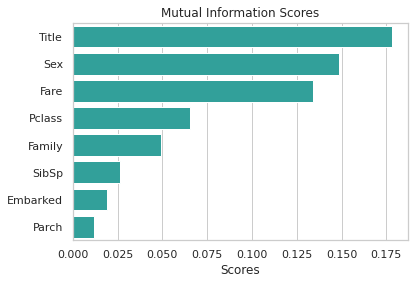

In [368]:
scores = make_plot_scores(train_data, 'Survived')
scores

We can see that the passengers' age is highly correlated to the title category. If clearly see this in the figure below:

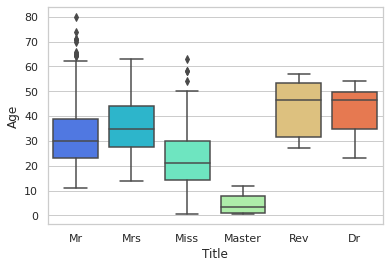

In [369]:
make_boxplot('Age', 'Title');

Taking into account the previous figure and the high influente of the title in the likelihood of survival, we might think that the age should also play an important role even though this was not considerably noticeable in previous figures. In order to dive into this, let's create age categories based on a split of the data every 5 years:

In [370]:
train_bins = train_copy.dropna(subset = ['Age']).copy()

max_age = train_bins['Age'].max()
min_age = train_bins['Age'].min()
print(f'The youngest passenger is {min_age} years old. The oldest passenger is {max_age} years old.')
list_bins_age = list(np.arange(0, max_age+1, 5))

train_bins['AgeBin'] = pd.cut(train_bins['Age'], bins = list_bins_age, include_lowest = True)

The youngest passenger is 0.42 years old. The oldest passenger is 80.0 years old.


Let's now look at the inluence of the age category in the status:

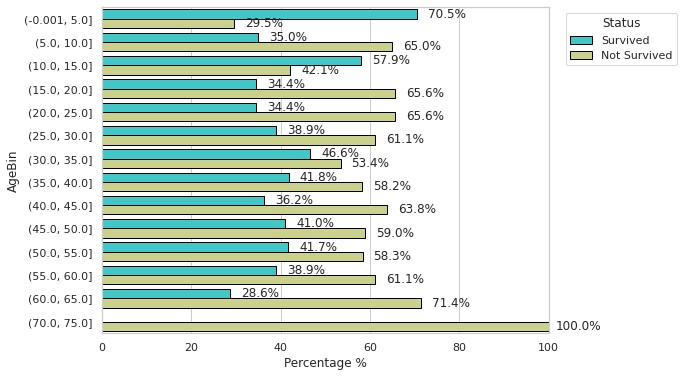

In [371]:
ax, fg = make_barplot('Status', 'AgeBin', dataset = train_bins, horizontal=True)
ax.legend(loc='upper right', title='Status', bbox_to_anchor=(1.3, 1))
fg.set_size_inches(8,6);

We can see that small children are more prone to survive whereas the mortality tends to increase with age and older people having high risk.

If we compute again the feature correlations including 'AgeBin' category we can see the latter performs much better than 'Age' did.

Title       0.177860
Sex         0.148409
Fare        0.133968
Pclass      0.065163
Family      0.049328
SibSp       0.026564
AgeBin      0.024466
Embarked    0.019310
Parch       0.011632
Name: Scores, dtype: float64

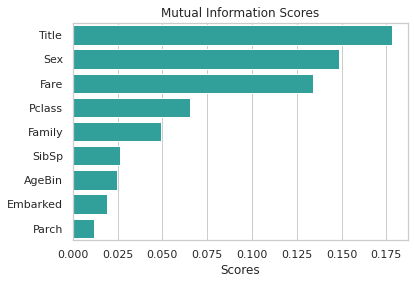

In [372]:
make_plot_scores(train_bins.loc[:, train_bins.columns != 'Status'], 'Survived')

## 5. Fill missing data

As previously seen, missing data remain in 'Embarked' and 'Age'. In the former, we simply remove those two rows as they are not going to have any impact in the final result.

In [373]:
train_data.dropna(subset = ['Embarked'], inplace=True)

In the case of 'Age', we fill those missing values by using the mean age per title. We look at the title for this process as it was the feature most related to the age. Once those missing values are filled, we create the age categories based on all the current filled ages.

In [374]:
from sklearn.base import BaseEstimator, TransformerMixin

class fillMissingAge(BaseEstimator, TransformerMixin):
    def __init__(self):
        super().__init__()

    def fit(self,X,y=None):
        return self

    def transform(self, X, y=None):
        X_copy  = train_data.loc[:,['Title','Age']]
        mean_age_bygroup = X_copy.groupby(['Title']).Age.mean().reset_index()
        X_transformed = X.copy()

    # Substitute nan age values by mean age 
        #for title, mean_age in zip(mean_age_bygroup.Title, mean_age_bygroup.Age): 
        for title, mean_age in mean_age_bygroup.items():        
            
             age_filled = X_copy.loc[lambda df: df.loc[:,'Title'] == title, :].fillna({'Age': mean_age})
             X_copy.loc[lambda df: df.loc[:,'Title'] == title, :] = age_filled
             X_transformed['AgeBin'] = pd.cut(X_copy['Age'], bins = list_bins_age, include_lowest = True)

        return X_transformed

## 6. Pipeline and learning models

Now we need to define the final data that is going to be used for the learning models. To that end, we first split the target and features into a dataframe and a series. Secondly, we select the features on which the predictions will be based. In this way, the 'PassengerId' is removed as it does not have any influence on the survival rate. In addition, both 'Parch' and 'SibSp' are removed as they are already included in the 'Family' feature, which has higher influence on the mortality than these two features alone. Finally, the 'Age' feature is removed as we will be using the 'AgeBin' feature instead because it was observed to be more determinant on whether the passenger survived or not.

In [375]:

# We split the target and features 
X_train  = train_data.drop('Survived',axis=1)
y_train = train_data['Survived']

# We drop unnecessary features
X_train.drop(['PassengerId', 'Parch', 'SibSp','Age'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Parch', 'SibSp','Age'], axis=1, inplace=True)

We now define the transformations that are going to be applied in the train data. In the case of numerical features, a standard scaler is used to set the mean value in zero and a standard deviation of one of the whole feature distributions. This is done in order to accelerate the model learning and also facilitate the convergence of results. In the case of categorical values, labels are used in order to treat properly treat these data.

In [376]:
# Scale the numerical data
num_transformer = Pipeline(steps=[('scale', StandardScaler())])
cols_num = list(X_train.columns[(X_train.dtypes == 'int64') | (X_train.dtypes == 'float64')])

# Assign labels to categorical data
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown= 'ignore'))])
cols_cat = list(X_train.columns[(X_train.dtypes == 'object') | (X_train.dtypes == 'category')])

# Preprocessing: scaling and labeling of columns
preprocessing = ColumnTransformer(transformers=[('num', num_transformer, cols_num),('cat', cat_transformer, cols_cat)])

In order to evaluate the performance of the model. we will use cross-valitation. In this way, the data is be further splitted into a train and validation dataset. The former is employed for training the model and the latter is used for making predictions based on the output obtained from the training process. The assement of the model is done by computing the accuracy of the algorithm in both the training and validation dataset. This whole process is repeatedly done in order to obtain a series of values out of which we can calculate the mean accuracies and their standard deviation. The repetition of this process ensures better representation of the data and does not only rely on an unique choice of training samples which could reflect the features' distribution properly. Hence, more reliability is achieved by looking at different subsets. 

Furthermore, learning curves are computed also based on cross-validation. Learning curves are important in order to evaluate if overfitting or underfitting would take place. The latter implies poor performance on the training data and thus the model needs to more refined to achieve a satisfactory accuracy. The former however implies that the model performs quite well on the training data but is not good for generalising, that is, it is too sensible to any changes in the data and does not lead to good predictions when applied to new values. In this case, the learning curves illustrate the accuracy variation as a function of number of the training samples for both the validation and training data. If both accuracies converge to a value together and the accuracy value is high, the model will be suitable for future predictions. However, if the accuracies converge to a low value means that the model is underfitting. In the case of overfitting, no convergence is achieved and there a gap remains between the training and validation accuracies.

As aforementioned, a series of classification models are tested and a selection is based based on their accuracy. In addition, an evaluation of model's parameters is done in order to improve the performance.

In [377]:
def plot_val_curve(model_name, param_name, param_list, get_train_test_scores, X_train, y_train, my_pipeline):
    
    train_scores, val_scores = get_train_test_scores(model_name, my_pipeline, X_train, y_train, param_name, param_list)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(val_scores, axis=1)
    val_scores_std = np.std(val_scores, axis=1)

    pos_max = np.argmax(val_scores_mean)
    
    print(f'The maximum mean accuracy achieved in validation set is {round(np.max(val_scores_mean)*100,1)}% with {param_name}={param_list[pos_max]}')

    plt.figure()
    plt.title(f'{model_name} - Validation Curve')

    plt.xlabel(f'{param_name}')
    plt.ylabel('Score')
    plt.ylim([0.6, 0.9])

    plt.grid(True)
    lw=2

    plt.semilogx(param_list, train_scores_mean, label='Training score', color='lightgreen', lw=lw)
    plt.fill_between(param_list, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2, color='lightgreen', lw=lw)
    plt.semilogx(param_list, val_scores_mean, label='Cross-validation score', color='hotpink', lw=lw)
    plt.fill_between(param_list, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2, color='hotpink', lw=lw)

    plt.legend(loc="best")
    
    return plt.gca()

In [378]:
    
def get_train_test_scores(model_name, my_pipeline, X_train, y_train, param_name, param_list):
    param_name_transform = model_name.lower().replace(" ", "") + '__' + param_name
    
    print(f'{model_name}: {param_name} parameter variation.')

    train_scores, val_scores = validation_curve(my_pipeline, X_train, y_train, 
                                             param_name =param_name_transform,
                                             param_range = param_list, cv = 5)

    return train_scores, val_scores

In [379]:
# Learning Curve
def plot_learning_curve(model_name, X_train, y_train, my_pipeline):

    train_sizes, train_scores, test_scores = learning_curve(my_pipeline, X_train, y_train, cv = 5)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    val_scores_mean = np.mean(test_scores, axis=1)
    val_scores_std = np.std(test_scores, axis=1)


    plt.title(f'{model_name} - Learning Curve')

    plt.xlabel('Training samples')
    plt.ylabel('Score')
    plt.ylim([0.7, 0.9])

    plt.grid(True)
    lw=2

    plt.plot(train_sizes, train_scores_mean, 'o-', label='Training score', color='darkturquoise')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.2,color='darkturquoise', lw=lw)
    plt.plot(train_sizes, val_scores_mean, 'o-', label='Validation score', color= 'darkorange')
    plt.fill_between(train_sizes, val_scores_mean - val_scores_std, val_scores_mean + val_scores_std, alpha=0.2, color='darkorange', lw=lw)

    print(f'The maximum mean accuracy achieved in validation set is {round(np.max(val_scores_mean)*100,1)}%')
    

    plt.legend(loc="best")

    return plt.gca()

### 6.1. Logistic Regression

Logistic regression is the first model to be tested, which is based on a sigmoid function for classification. In this case, we look at the influence of C parameter in the accuracy of results, which represents the inverse of regularization strength. Keep in mind that regularization is an important step in order to minimize the risk of overfitting.

Logistic Regression: C parameter variation.
The maximum mean accuracy achieved in validation set is 82.3% with C=1


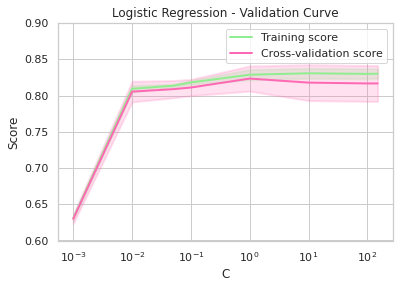

In [380]:
# Parameters
C_list = [0.001, 0.01, 0.05, 0.1, 1, 10, 100, 150]

# Logistic Regression
class_model = LogisticRegression(max_iter=500)
my_pipeline = make_pipeline(fillMissingAge(),preprocessing,class_model)

plot_val_curve('Logistic Regression', 'C', C_list, get_train_test_scores, X_train, y_train, my_pipeline);
# We select C=1 based on the previous plot

The maximum accuracy achieved was 82.3% with C=1. Based on this result, we compute the learning curve:

The maximum mean accuracy achieved in validation set is 82.3%


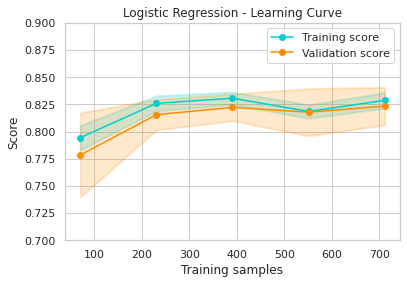

In [381]:
# Plot learning curves
class_model = LogisticRegression(C= 1) 
plot_learning_curve('Logistic Regression', X_train, y_train, my_pipeline);

As observed, both curves converge to a value around 80% of accuracy. This means that the model performs well and leads to good accuracy levels.

### 6.2. SVC - Linear kernel

The next model is Linear Support Vector Classification (SVC), where a linear approach is used.

Linear SVC: C parameter variation.
/home/marc/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
The maximum mean accuracy achieved in validation set is 82.6% with C=1


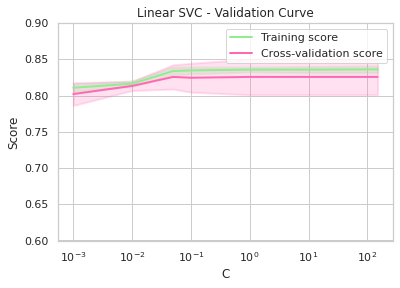

In [382]:
# Parameters
C_list = [0.001, 0.01, 0.05, 0.1, 1, 10, 100, 150]

# Linear SVC
class_model = LinearSVC(max_iter = 80000, tol=1e-1)
my_pipeline = make_pipeline(fillMissingAge(),preprocessing,class_model)

plot_val_curve('Linear SVC', 'C', C_list, get_train_test_scores, X_train, y_train, my_pipeline);
# We select C=1 based on the previous plot

In this case, the maximum number of iterations had to increase significately to 80k (default value being 1k) and the tolerance had to be increased to 0.1 (default value being 1e-4) in order to achieve convergence with all the tested parameters. Once these changes were applied, the maximum accuracy achieved was 82.6% with C=1. Based on this result, we compute the learning curve:

The maximum mean accuracy achieved in validation set is 82.7%


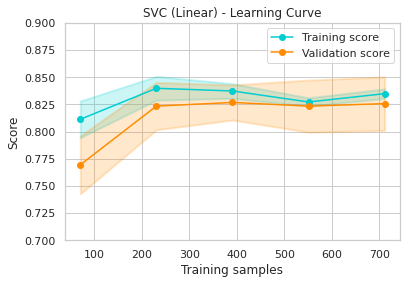

In [383]:
# Plot learning curves
class_model = LinearSVC(C= 1)
plot_learning_curve('SVC (Linear)', X_train, y_train, my_pipeline);

As observed, quick convergence was achieved above 80% of accuracy, showing a good performance of the model in terms of overfitting and underfitting. Additionally, no convergence issues arose with C=1 by setting the tolerance and maximum number of iterations to the defatult values. 

### 6.3. SVC - RBF kernel

We continue with SVC classifier based on the radial basis function (RBF) kernel, which uses a nonlinear approach to find the boundaries. In this case, we are going to look at the C parameter as well as the kernel coefficient gamma.

SVC: gamma parameter variation.
The maximum mean accuracy achieved in validation set is 83.4% with gamma=0.1
SVC: C parameter variation.
The maximum mean accuracy achieved in validation set is 83.4% with C=1


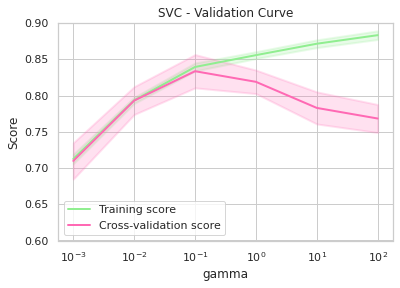

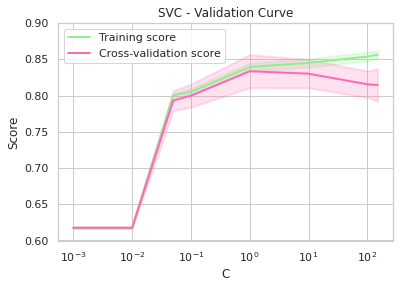

In [384]:
# Parameters 
C_list = [0.001, 0.01, 0.05, 0.1, 1, 10, 100, 150]
g_list = [0.001, 0.01, 0.1, 1, 10, 100]

# SVC - RBF kernel (default kernel)
class_model = SVC()
my_pipeline = make_pipeline(fillMissingAge(),preprocessing,class_model)
plot_val_curve('SVC', 'gamma', g_list, get_train_test_scores, X_train, y_train, my_pipeline);
# We choose gamma = 0.1 based on previous plot

class_model = SVC(gamma=0.1)
my_pipeline = make_pipeline(fillMissingAge(),preprocessing,class_model)
plot_val_curve('SVC', 'C', C_list, get_train_test_scores, X_train, y_train, my_pipeline);
# We choose C = 1 based on previous plot

The highest accuracy obtained for SVC with RBF kernel is 83.4% with C=1 and gamma=0.1. Based on these results, we compute the learning curve:

The maximum mean accuracy achieved in validation set is 83.6%


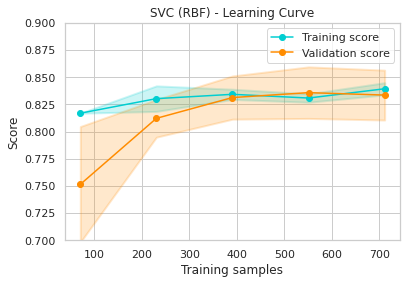

In [385]:
# Plot learning curves
class_model = SVC(gamma=0.1, C=1)
plot_learning_curve('SVC (RBF)', X_train, y_train, my_pipeline);

Satisfactory convergence is observed above 80% of accuracy. Thus, the SVC classifier with RBF provides good performance without overfitting nor underfitting concerns.

### 6.4. SVC - Polynomial kernel

We now look at SVC classifier with polynomial kernel. Here, an additional determinant parameter to define is the polynomial degree plus the gamma and C parameters.

SVC: gamma parameter variation.
The maximum mean accuracy achieved in validation set is 83.0% with gamma=0.1
SVC: degree parameter variation.
The maximum mean accuracy achieved in validation set is 83.2% with degree=2
SVC: C parameter variation.
The maximum mean accuracy achieved in validation set is 83.2% with C=1


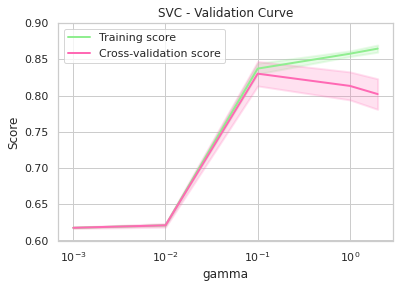

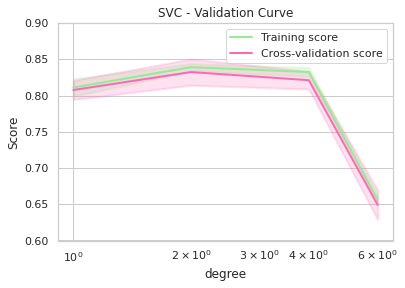

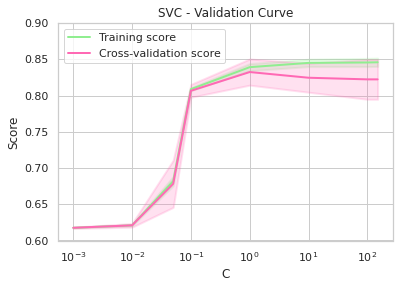

In [386]:
# Parameters
degree_list=[1, 2, 4, 6]
C_list=[0.001, 0.01, 0.05, 0.1, 1, 10, 100, 150]
g_list = [0.001, 0.01, 0.1, 1, 2]

# Support Vector Machines - Polynomial


class_model = SVC(kernel='poly')
my_pipeline = make_pipeline(fillMissingAge(),preprocessing,class_model)
plot_val_curve('SVC', 'gamma', g_list, get_train_test_scores, X_train, y_train, my_pipeline);
# We select gamma = 0.1

class_model = SVC(kernel='poly', gamma=0.1)
my_pipeline = make_pipeline(fillMissingAge(),preprocessing,class_model)
plot_val_curve('SVC', 'degree', degree_list, get_train_test_scores, X_train, y_train, my_pipeline);
# We select degree=2

class_model = SVC(kernel='poly', gamma=0.1, degree=2)
my_pipeline = make_pipeline(fillMissingAge(),preprocessing,class_model)
plot_val_curve('SVC', 'C', C_list, get_train_test_scores, X_train, y_train, my_pipeline);
# We select C = 1

The best fit of 82% accuracy is obtained with parameters C=1, gamma=0.1, and degree=2. 

The maximum mean accuracy achieved in validation set is 83.2%


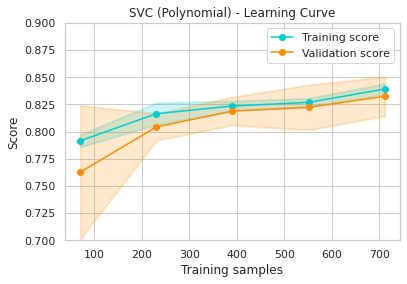

In [387]:
# Plot learning curves
class_model = SVC(kernel='poly',gamma=0.1, C=10, degree=2)
plot_learning_curve('SVC (Polynomial)', X_train, y_train, my_pipeline);

As observed in the figure above, quick convergence is achieved above 80% of accuracy and thus good performance is obtained.

### 6.5. Decision Tree Classifier

Another algorithm that is tested is the decision tree classifier. This model is based on simple decision rules based on the input features that progressively splits the data for classification. Here, we are going to look at the maximum depth of the decision tree, that is, the maximum number of decision nodes or data splits levels until a leaf node is reached representing a class label. In addition, variation in the maximum number of leaf nodes parameter is also tested.

DecisionTreeClassifier: max_depth parameter variation.
The maximum mean accuracy achieved in validation set is 82.5% with max_depth=4
DecisionTreeClassifier: max_leaf_nodes parameter variation.
The maximum mean accuracy achieved in validation set is 82.6% with max_leaf_nodes=25


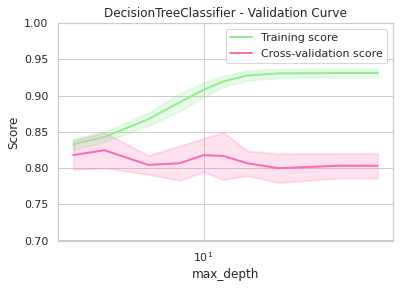

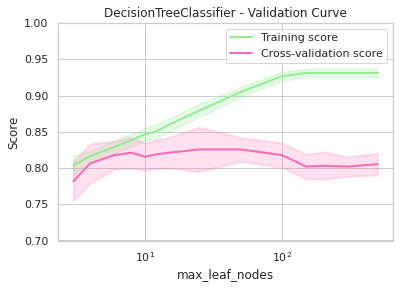

In [388]:
# Parameters
depth_list= [3, 4, 6, 8, 10, 12, 15, 20, 35, 50]
nodes_list= [3, 4, 6, 8, 10, 12, 15,25,50,100,150,200,300,500]

# Decision Tree Classifier
class_model = DecisionTreeClassifier()
my_pipeline = make_pipeline(fillMissingAge(),preprocessing,class_model)
pt = plot_val_curve('DecisionTreeClassifier', 'max_depth', depth_list, get_train_test_scores, X_train, y_train, my_pipeline);
pt.set_ylim([0.7,1.0]);
# We choose max_depth=4 based on previous plot

class_model = DecisionTreeClassifier(max_depth=4)
pt = plot_val_curve('DecisionTreeClassifier', 'max_leaf_nodes', nodes_list, get_train_test_scores, X_train, y_train, my_pipeline);
pt.set_ylim([0.7,1.0]);

The maximum mean accuracy achieved in validation set is 80.7%


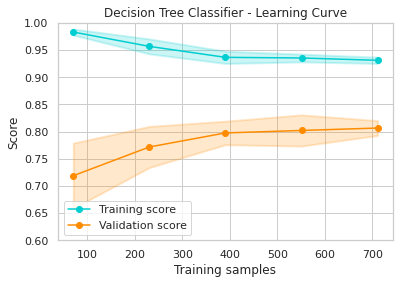

In [389]:
# Plot learning curves
class_model = DecisionTreeClassifier(max_depth=4, max_leaf_nodes=25)
pt = plot_learning_curve('Decision Tree Classifier', X_train, y_train, my_pipeline);
pt.set_ylim([0.6,1.0]);

Looking at the learning curves, we can see that decision trees classifier overfits. The curves do not converge and a gap remains when the maximum number of training samples is achieved. Thus, this model is not good for generalising and does not perform well in new datasets which were not used for training the model. 

### 6.6. Model Selection

Based on the previous results, the model that better performed was the SVC with RBF kernel based on a non-linear approximation with parameters gamma=0.1 and C=1. Thus, this model is selected as the most appropiate one to make future predictions. Nonetheless, the majority of the models led to satisfactories accucaries and fitting performance.

In [390]:
class_model = SVC(gamma=0.1, C=1)

## 7. Features' impact on accuracy

Let's now see how the model would perform if we only keep the most influential feature of 'Title':

In [391]:
X_train_1ft  = train_data[['Title',]]

We need to update the preprocessing step again:

In [392]:
# Scale the numerical data
num_transformer = Pipeline(steps=[('scale', StandardScaler())])
cols_num = list(X_train_1ft .columns[(X_train_1ft .dtypes == 'int64') | (X_train_1ft .dtypes == 'float64')])

# Assign labels to categorical data
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown= 'ignore'))])
cols_cat = list(X_train_1ft .columns[(X_train_1ft .dtypes == 'object') | (X_train_1ft .dtypes == 'category')])

# Preprocessing: scaling and labeling of columns
preprocessing = ColumnTransformer(transformers=[('num', num_transformer, cols_num),('cat', cat_transformer, cols_cat)])

Now let's look at the learning curves:

The maximum mean accuracy achieved in validation set is 78.6%


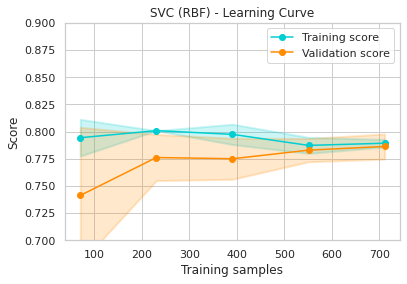

In [393]:
my_pipeline = make_pipeline(preprocessing,class_model)
plot_learning_curve('SVC (RBF)', X_train_1ft , y_train, my_pipeline);

We can see that only using the title we can already achieve 78.6% of accuracy! Let's now add the 'Fare' feature and see how the results change:

In [394]:
X_train_3ft  = train_data[['Title','Fare']]

In [395]:
# Scale the numerical data
num_transformer = Pipeline(steps=[('scale', StandardScaler())])
cols_num = list(X_train_3ft.columns[(X_train_3ft.dtypes == 'int64') | (X_train_3ft.dtypes == 'float64')])

# Assign labels to categorical data
cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown= 'ignore'))])
cols_cat = list(X_train_3ft.columns[(X_train_3ft.dtypes == 'object') | (X_train_3ft.dtypes == 'category')])

# Preprocessing: scaling and labeling of columns
preprocessing = ColumnTransformer(transformers=[('num', num_transformer, cols_num),('cat', cat_transformer, cols_cat)])

The maximum mean accuracy achieved in validation set is 78.9%


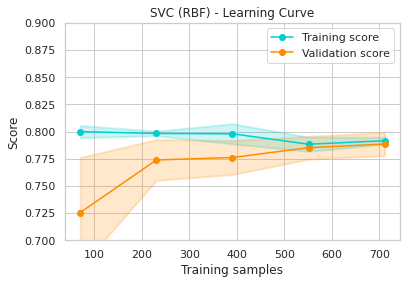

In [396]:
my_pipeline = make_pipeline(preprocessing,class_model)
plot_learning_curve('SVC (RBF)', X_train_3ft, y_train, my_pipeline);

Now the accuracy obtained is 78.9% with only the two features of title and fare. As we can see, the accuracy keeps increasing by small steps when adding additional features.  

## 8. Test data - make predictions

Based on the selected model, we now make predictions on a new dataset:

In [397]:
class_model = SVC(gamma=0.1, C=1)
my_pipeline = make_pipeline(fillMissingAge(),preprocessing,class_model)
my_pipeline.fit(X_train,y_train)

Pipeline(steps=[('fillmissingage', fillMissingAge()),
                ('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scale',
                                                                   StandardScaler())]),
                                                  ['Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Title'])])),
                ('svc', SVC(C=1, gamma=0.1))])

In [398]:
test_data.dropna(subset = ['Fare'], inplace=True) # We remove one row with missing fare value
y_test = my_pipeline.predict(test_data)
print(f'{y_test.sum()} people out of {len(y_test)} passengers are predicted to survive from the test dataset')

176 people out of 417 passengers are predicted to survive from the test dataset
